## Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク1

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### 2.1次元の畳み込みニューラルネットワークスクラッチ


畳み込みニューラルネットワーク（CNN） のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

このSprintでは1次元の 畳み込み層 を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。

クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。

畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

#### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。

ここでは パディング は考えず、ストライド も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

フォワードプロパゲーションの数式は以下のようになります。



$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [47]:
from scipy.sparse import dia_matrix
class SimpleConv1d:
    def __init__(self, weight, baias):
        self.optimizer = None

        self.W = weight
        self.B = baias
        self.dW = None
        self.dB = None
        self.idx =None
        self.X = None
        pass
    def output(self,X):
        n_in = X.shape[1]
        p = 0 #バディング
        f = self.W.shape[0] #フィルタのサイズ
        s = 1 #ストライドのサイズ
        n_out = ((n_in + 2*p - f)/s)+1
        return n_out
    def forward(self, X):
        #配列
        self.a = X.copy()
        idx1 = np.arange(self.W.shape[0])
        idx2 = np.arange(self.W.shape[0]-1 ).reshape(-1, 1)
        self.idx = idx1 + idx2
        A = np.sum(X[self.idx] * self.W.T,axis=1) + self.B
        return A
    def backward(self, dX,dA):

        dB = np.sum(dA,axis=0)
        dW = np.sum(dA[:,np.newaxis] *dX[idx],axis=0)
        #scipyを利用した
        da = dA.reshape(-1,1)
        data= np.repeat(da,dX.shape[0],axis=1)
        offsets= np.arange(self.output(self.a))
        d = dia_matrix((data,offsets),shape=(w.shape[0],x.shape[0])).toarray()
        dx = np.sum(d * w[:,np.newaxis],axis=0)
        # 更新
        #self = self.optimizer.update(self)
        return dX

In [48]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        #print("dB",layer.dB.shape)
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW
        return 

#### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。
$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

In [49]:
def output(X,p,f,s):
    n_in = X.shape[0]
    p = p #バディング
    f = f #フィルタのサイズ
    s = s #ストライドのサイズ
    n_out = ((n_in + 2*p - f)/s)+1
    return n_out


In [50]:
    # n_in = x.shape[1]
    # p = 0 #バディング
    # f = 3 #フィルタのサイズ
    # s = 1 #ストライドのサイズ
    # n_out = ((n_in + 2*p - f)/s)+1
    # n_out

#### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みw、バイアスbを次のようにします。

In [51]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

フォワードプロパゲーションをすると出力は次のようになります。

In [52]:
x.shape,w.shape,b.shape

((4,), (3,), (1,))

In [53]:
a = np.array([35, 50])

In [54]:
#配列
idx1 = np.arange(w.shape[0])
print(idx1)
idx2 = np.arange(w.shape[0]-1 ).reshape(-1, 1)
print(idx2)
idx = idx1 + idx2
print(idx)
print(x[idx])
a = np.sum(x[idx] * w.T,axis=1) + b
print(x[idx] * w.T)
print(a)



[0 1 2]
[[0]
 [1]]
[[0 1 2]
 [1 2 3]]
[[1 2 3]
 [2 3 4]]
[[ 3 10 21]
 [ 6 15 28]]
[35 50]


In [55]:
sc1 = SimpleConv1d(w,b)
sc1.forward(x)

array([35, 50])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [56]:
delta_a = np.array([10, 20])
delta_a.shape

(2,)

バックプロパゲーションをすると次のような値になります。

In [57]:
delta_b = np.array([30])
delta_w = np.array([50, 80, 110])
delta_x = np.array([30, 110, 170, 140])

In [58]:
dB = np.sum(delta_a,axis=0)
dB

30

In [59]:
dW = np.sum(delta_a[:,np.newaxis] *x[idx],axis=0)
dW

array([ 50,  80, 110])

In [60]:
# #配列
# jdx = np.arange(x.shape[0])
# print(jdx)
# sdx = np.arange(w.shape[0] ).reshape(-1, 1)
# print(sdx)
# j_s = jdx - sdx
# print(j_s)
# for i in j_s:
#     if i < 0 or i >1:
#         j_s = 0
#     else:
#         dx = delta_a[i]
# #思いつかﾂﾞ断念

In [61]:
dx = np.zeros(x.shape[0])
for j in range(x.shape[0]):
    for s in range(w.shape[0]):
        if j-s < 0 or j-s >1:
            dx[j] += 0
        else:
            dx[j] += delta_a[j - s] * w[s]
dx

array([ 30., 110., 170., 140.])

In [62]:
from scipy.sparse import dia_matrix
#scipyを利用した
da = delta_a.reshape(-1,1)
print(da)
data= np.repeat(da,x.shape[0],axis=1)
print(data)
offsets= np.arange(0,int(output(x,0,3,1)))
print(offsets)
da = dia_matrix((data,offsets),shape=(w.shape[0],x.shape[0])).toarray()
print(da)
# 更新

[[10]
 [20]]
[[10 10 10 10]
 [20 20 20 20]]
[0 1]
[[10 20  0  0]
 [ 0 10 20  0]
 [ 0  0 10 20]]


In [63]:
dx = np.sum(da * w[:,np.newaxis],axis=0)
dx

array([ 30, 110, 170, 140])

In [64]:
# sc1 = SimpleConv1d(delta_w,delta_b)
# sc1.backward(delta_x,delta_a)

実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$
バイアス項は単純な足し算のため、重みの部分を見ます。
$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$
これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

In [65]:
x = np.array([1, 2, 3, 4])
w = np.array([3, 5, 7])
a = np.empty((2, 3))
indexes0 = np.array([0, 1, 2]).astype(np.int)
indexes1 = np.array([1, 2, 3]).astype(np.int)
a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である

a = a.sum(axis=1)

In [66]:
a

array([34., 49.])

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。


In [67]:
x = np.array([1, 2, 3, 4])
indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

[[1 2 3]
 [2 3 4]]


このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

《参考》

以下のページのInteger array indexingの部分がこの方法についての記述です。
[Indexing — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

#### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

例えば以下のようなx, w, bがあった場合は、

In [68]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになります。

In [69]:
a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

《補足》

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。(バッチサイズ、チャンネル数、特徴量数)または(バッチサイズ、特徴量数、チャンネル数)が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、(チャンネル数、特徴量数)です。

In [70]:
x

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

In [863]:
x.shape

(2, 4)

In [862]:
w.shape

(3, 2, 3)

In [73]:
def output2(X,p,f,s):
    n_in = X.shape[1]
    p = p #バディング
    f = f #フィルタのサイズ
    s = s #ストライドのサイズ
    n_out = ((n_in + 2*p - f)/s)+1
    return n_out


In [74]:
#o　出力サイズ
o = int(output2(x,0,w.shape[-1],1))
o

2

In [75]:
#o　出力サイズ
o = int(output2(x,0,w.shape[-1],1))
print(o)
#ninチャンネル  , i　特徴量
nin, i = x.shape
print(nin,i)
#oc出力チャンネル , cチャンネル数 , fフィルタサイズ
oc, c, f = w.shape
print(oc,c,f)


2
2 4
3 2 3


In [76]:
#c * f 
idx_arr = np.arange(c*f).reshape(c,f)
idx_arr

array([[0, 1, 2],
       [3, 4, 5]])

In [77]:
# A = np.zeros((oc,o))
# for oc in range(oc):
#     for ni in range(nin):
#         for o in range(o):
#             A[oc , o] += np.sum(x[ni, o:o+f] * w[oc, ni, :])
#             print(A)
# print(A)

In [78]:
#フォワード
idx1 = np.arange(w.shape[-1])

idx2 = np.arange(w.shape[-1]-1 ).reshape(-1, 1)

idx = idx1 + idx2

print(x[:,idx].shape)
a1 = x[:,idx]
a2 = w
print(a1)
a= np.zeros((f,o))
for i in range(f):
    for j in range(o):
        x_in = a1[j]
        print(x_in.shape)
        a[i][j] = np.sum(x_in @ w[i][j])
        print('a',a.shape)
    print(b[i].shape)
    a[i] += a[i] + b[i]
    print(a)


(2, 2, 3)
[[[1 2 3]
  [2 3 4]]

 [[2 3 4]
  [3 4 5]]]
(2, 3)
a (3, 2)
(2, 3)
a (3, 2)
()
[[31. 43.]
 [ 0.  0.]
 [ 0.  0.]]
(2, 3)
a (3, 2)
(2, 3)
a (3, 2)
()
[[31. 43.]
 [32. 44.]
 [ 0.  0.]]
(2, 3)
a (3, 2)
(2, 3)
a (3, 2)
()
[[31. 43.]
 [32. 44.]
 [33. 45.]]


In [79]:
w.shape

(3, 2, 3)

In [80]:
a1

array([[[1, 2, 3],
        [2, 3, 4]],

       [[2, 3, 4],
        [3, 4, 5]]])

In [81]:
output2(x,0,w.shape[-1],1) - 1


1.0

In [82]:
#バックプロパゲーション
db = np.sum(a,axis=1)
db

array([74., 76., 78.])

In [83]:
w

array([[[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [409]:
w.shape

(3, 2, 3)

In [84]:
a1

array([[[1, 2, 3],
        [2, 3, 4]],

       [[2, 3, 4],
        [3, 4, 5]]])

In [408]:
a1.shape

(2, 2, 3)

In [85]:
a

array([[31., 43.],
       [32., 44.],
       [33., 45.]])

In [407]:
a.shape

(3, 2)

In [86]:
aa1 = a1.flatten()
len(aa1)

12

In [87]:
aa = a.flatten()
aa

array([31., 43., 32., 44., 33., 45.])

In [406]:
aa.shape

(6,)

In [88]:
aaa = aa[:,np.newaxis]
aaa

array([[31.],
       [43.],
       [32.],
       [44.],
       [33.],
       [45.]])

In [405]:
aaa.shape

(6, 1)

In [89]:
aaaa = aaa * aa1
aaaa

array([[ 31.,  62.,  93.,  62.,  93., 124.,  62.,  93., 124.,  93., 124.,
        155.],
       [ 43.,  86., 129.,  86., 129., 172.,  86., 129., 172., 129., 172.,
        215.],
       [ 32.,  64.,  96.,  64.,  96., 128.,  64.,  96., 128.,  96., 128.,
        160.],
       [ 44.,  88., 132.,  88., 132., 176.,  88., 132., 176., 132., 176.,
        220.],
       [ 33.,  66.,  99.,  66.,  99., 132.,  66.,  99., 132.,  99., 132.,
        165.],
       [ 45.,  90., 135.,  90., 135., 180.,  90., 135., 180., 135., 180.,
        225.]])

In [404]:
aaaa.shape

(6, 12)

In [412]:
b=  aaaa.reshape((18,4))
b

array([[ 31.,  62.,  93.,  62.],
       [ 93., 124.,  62.,  93.],
       [124.,  93., 124., 155.],
       [ 43.,  86., 129.,  86.],
       [129., 172.,  86., 129.],
       [172., 129., 172., 215.],
       [ 32.,  64.,  96.,  64.],
       [ 96., 128.,  64.,  96.],
       [128.,  96., 128., 160.],
       [ 44.,  88., 132.,  88.],
       [132., 176.,  88., 132.],
       [176., 132., 176., 220.],
       [ 33.,  66.,  99.,  66.],
       [ 99., 132.,  66.,  99.],
       [132.,  99., 132., 165.],
       [ 45.,  90., 135.,  90.],
       [135., 180.,  90., 135.],
       [180., 135., 180., 225.]])

In [413]:
np.sum(b,axis=1).reshape(3,2,3)

array([[[248., 372., 496.],
        [344., 516., 688.]],

       [[256., 384., 512.],
        [352., 528., 704.]],

       [[264., 396., 528.],
        [360., 540., 720.]]])

In [92]:
b = np.zeros((oc*c*f))
b

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [93]:
a[:,:,np.newaxis]

array([[[31.],
        [43.]],

       [[32.],
        [44.]],

       [[33.],
        [45.]]])

In [94]:
w[0][:,:,np.newaxis]

array([[[1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.]]])

In [95]:
a1

array([[[1, 2, 3],
        [2, 3, 4]],

       [[2, 3, 4],
        [3, 4, 5]]])

In [96]:
from scipy.sparse import dia_matrix
#scipyを利用した
dd = 0
for i in range(a.shape[0]):
    da = a[:,:,np.newaxis]
    #print(da)
    data= np.repeat(da[i],x.shape[1],axis=1)
    #print(data)
    offsets= np.arange(int(output2(x,0,3,1)))
    #print(offsets)
    da = dia_matrix((data,offsets),shape=(w.shape[-1],x.shape[1])).toarray()
    print(da)
    # 更新
    dd += np.sum(da * w[i][:,:,np.newaxis],axis=1)
    print(dd)
    

[[31. 43.  0.  0.]
 [ 0. 31. 43.  0.]
 [ 0.  0. 31. 43.]]
[[31. 74. 74. 43.]
 [31. 74. 74. 43.]]
[[32. 44.  0.  0.]
 [ 0. 32. 44.  0.]
 [ 0.  0. 32. 44.]]
[[ 63. 150. 150.  87.]
 [ 63. 150. 150.  87.]]
[[33. 45.  0.  0.]
 [ 0. 33. 45.  0.]
 [ 0.  0. 33. 45.]]
[[ 96. 228. 228. 132.]
 [ 96. 228. 228. 132.]]


#### 【問題5】（アドバンス課題）パディングの実装
畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。

最も単純なパディングは全て0で埋める ゼロパディング であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。

フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

[numpy.pad — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。


#### 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。

出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 平滑化 を行なってください。

画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

In [897]:
from scipy.sparse import dia_matrix
class Conv1d:
    def __init__(self,ch, f_num, f_size, initializer,optimizer):
        self.optimizer = optimizer

        self.W = initializer.W(f_num=f_num,f_size=f_size,ch=ch)
        self.B = initializer.B(f_num)
        self.dW = None
        self.dB = None
        self.idx =None
        self.X = None
        self.A = None
        pass

    def output(self,X,p,f,s):
        self.x_in = X.shape[-1]
        n_out = int(((self.x_in + 2*p - f)/s)+1)
        return n_out

    def forward(self, X):
        #print(X.shape)
        self.X = X
        #shape
        i_ch,featu = self.X.shape
        o_ch,i_ch,f_size = self.W.shape
        self.o_size = self.output(X,0,f_size,1)
        A = np.zeros((o_ch,self.o_size))

        idx1 = np.arange(f_size)
        idx2 = np.arange(f_size-1 ).reshape(-1, 1)
        idx = idx1 + idx2
        self.xs = X[:,idx]
        # for os in range(self.o_size):
        #     for oc in range(o_ch):
        #         x_in = self.xs[oc]
        #         print("x_in",x_in.shape)
        #         A[os,oc] = np.sum(x_in @ self.W[os,oc]) 
        #     A[os] += A[os] + self.B[os]
        #     print(A.shape)

        for oc in range(o_ch):
            for ic in range(i_ch):
                for os in range(self.o_size):
                    A[oc , os] += np.sum(self.X[ic, os:os+f_size] * self.W[oc, ic, :])
        A += self.B.reshape(-1,1)
        #print(A.shape)
        return A

    def backward(self, dA):
        i_ch,featu = self.X.shape
        o_ch,i_ch,f_size = self.W.shape
        #バックプロパゲーション
        #bias
        self.dB = np.sum(dA,axis=1)

        # #weight
        # x_flat = self.xs.flatten()
        # a_flat = dA.flatten()
        # print('a_flat',a_flat.shape)
        # x_to = x_flat[:,np.newaxis]
        # print('x_to',x_to.shape)
        # ax = x_to * a_flat
        # print('ax',ax.shape)
        # w_flat=  ax.reshape((self.o_ch*self.i_ch*self.f_size,self.featu))
        # self.dW = np.sum(w_flat,axis=1).reshape(self.o_ch,self.i_ch,self.f_size)

        self.dW = np.zeros(self.W.shape)
        for oc in range(o_ch):
            for ic in range(i_ch):
                for f in range(f_size):
                    for os in range(self.o_size):
                        self.dW[oc,ic,f] += dA[ic,os] * self.X[ic,f + os]
        #print('dB',self.dB.shape)
        #print('dW',self.dW.shape)
        #backpropa
        dX = 0
        for i in range(o_ch):
            da = dA[:,:,np.newaxis]
            data= np.repeat(da[i],i_ch,axis=1)
            offsets= np.arange(self.o_size)
            #print(offsets)
            da = dia_matrix((data,offsets),shape=(f_size,i_ch)).toarray()
            dX += np.sum(da * self.W[i][:,:,np.newaxis],axis=1)

         # 更新
        self = self.optimizer.update(self)
        return dX

In [898]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dW = None
        self.dB = None
        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X.copy()
        #print('X',X.shape)
        #print('W',self.W.shape)
        A= X @ self.W
        A = A + self.B
        return  A

    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        self.dB = np.sum(dA,axis=0) 
        self.dW = self.X.T @ dA
        dZ = dA @ self.W.T #次の層で使う
        # 更新
        self = self.optimizer.update(self)
        return dZ

In [899]:
class HeInitializer:
    def __init__(self):
        pass
    def W(self, n_nodes1=None, n_nodes2=None,f_num=None,f_size=None,ch=None):
        if f_num is not None:
            W = np.random.randn(f_num,ch,f_size)* np.sqrt(2/f_num)
        else:
            W = np.random.randn(n_nodes1,n_nodes2) * np.sqrt(2/n_nodes1)
        return W
    def B(self, n_nodes2):
        B = np.random.randn(n_nodes2)     
        return B

In [900]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        self.hb = 0.1
        self.hw = 0.1
    def update(self, layer):
        self.hb +=  (layer.dB) **2 
        self.hw += (layer.dW)**2
        layer.B -= self.lr / np.square(self.hb)*layer.dB
        layer.W -= self.lr / np.square(self.hw)*layer.dW
        return 

In [901]:
class ReLU:
    def __init__(self):
        self.A = None
    def forward(self, X):
        self.A = np.copy(X)
        return np.maximum(0,X)
    def backward(self, X):
        return np.where(self.A>0,X,0)

In [902]:
#softmax関数
class Softmax:
    def __init__(self):
        self.b = None
    def forward(self,x):
        self.b = np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)), axis =1, keepdims =True)
        return self.b
    def backward(self,t):
        self.batch = t.shape[0]
        loss = -1/self.batch * np.sum(np.sum(t*np.log(self.b),axis=0))
        dx = (self.b - t) /self.batch
        return dx, loss

In [903]:
from sklearn.metrics import accuracy_score
class GetMiniBatch:
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [904]:
#ハイパボリックタンジェント
class Tanh():
    def __init__(self):
        self.A = None
    def forward(self,X):
        self.A = np.tanh(X)
        return self.A
    def backward(self,X):
        return X * (1 - (np.tanh(self.A))**2)

In [905]:
class Flat():
    def __init__(self):
        self.X_shape = None
    def forward(self,X):
        x1d = X.reshape(X.shape[0],-1)
        self.X_shape = X.shape
        return x1d
    def backward(self,X):
        X = X.reshape(self.X_shape)
        return X

In [906]:
class Scratchch1dCNNNeuralNetrowkClassifier():    
    def __init__(self,lr=0.01,sigma=0.01,n_node1=200,n_node2=100,n_output=10,verbose=True,epoch=5,batch_size=10,activation="tanh",initial="simple",optimizer="sgd",f_num=10,f_size=100):
        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        self.lr = lr
        self.sigma = sigma
        self.n_nodes1 = n_node1
        self.n_nodes2 = n_node2
        self.n_output = n_output
        self.epoch = epoch
        self.verbose = verbose
        self.batch = batch_size
        self.activation = activation
        self.initial = initial
        self.optimizer = optimizer
        self.f_num = f_num
        self.f_size = f_size

    def fit(self,X,y,X_val=None,y_val=None):
        get_mini_batch = GetMiniBatch(X, y, self.batch)
        #val
        if X_val is not None:      
            test_mini_batch = GetMiniBatch(X_val, y_val) 

        self.inch = self.batch
        self.n_features = X.shape[1]

        if self.optimizer == "sgd":
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        elif self.optimizer == "ada":
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
            optimizer4 = AdaGrad(self.lr)

        if self.activation == "tanh":
            self.activation1 = Tanh()
            self.activation2= Tanh()
            self.activation3 = Tanh()
        elif self.activation == "sigmoid":
            self.activation1 = Sigmoid()
            self.activation2= Sigmoid()
        elif self.activation == "relu":
            self.activation1 = ReLU()
            self.activation2= ReLU()
            self.activation3= ReLU()

        if self.initial == "simple":
            initial = SimpleInitializer(self.sigma)
        elif self.initial == "xavier":
            initial = XavierInitializer()
        elif self.initial == "he":
            initial1 = HeInitializer()
            initial2 = HeInitializer()          
            initial3 = HeInitializer()
            initial4 = HeInitializer()           
        #1
        self.CON1 = Conv1d(self.inch,self.f_num,self.f_size,initial1,optimizer1)

        self.flat = Flat()
        out = int(X.shape[1] - (self.f_size -1))
        self.FC1 = FC(out, self.n_nodes1, initial2, optimizer2)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initial3, optimizer3)
        self.FC3 = FC(self.n_nodes2, self.n_output, initial4, optimizer4)
        
        self.activation4 = Softmax()

        self.epo_lis = []
        self.loss_lis = []
        self.val_lis = []
        for i in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                Y = (mini_y_train.reshape(-1,1)==np.arange(10)).astype(np.float64)
                self._forward(mini_X_train)

                dA4, loss = self.activation4.backward(Y) 
                #print(loss)# 交差エントロピー誤差とソフトマックスを合わせている
                #print("dA3",dA3.shape)
                dZ4 = self.FC3.backward(dA4)
                #print("dZ4",dZ4.shape )
                dA3 = self.activation3.backward(dZ4)
                #print('dA3',dA3)
                dZ3 = self.FC2.backward(dA3)
                #print('dZ3',dZ3)
                dA2 = self.activation2.backward(dZ3)
                #print('dA2',dA2)
                dZ2 = self.FC1.backward(dA2) 
                #print('dZ2',dZ2)
                dF = self.flat.backward(dZ2)
                #print('dF',dF)
                dA1 = self.activation1.backward(dF)
                #print('dA1',dA1)
                dZ1 = self.CON1.backward(dA1)
                #print('dZ1',dZ1)
            self.loss_lis.append(loss)
            #検証
            if X_val is not None:
                for mini_X_val,mini_y_val in test_mini_batch:
                    y_val_one = (mini_y_val.reshape(-1,1)==np.arange(10)).astype(np.float64)
                    y_pre = np.argmax(self._forward(mini_X_val)  ,axis=1)
                    accura = accuracy_score(mini_y_val,y_pre)
                self.val_lis.append(self.activation4.backward(y_val_one)[1])
            self.epo_lis.append(i+1)
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose:
                print( "epoch",i+1,"loss{:.3f}".format(loss),"accuracy:",accura,"ini",self.initial,"activation",self.activation,"optimizer",self.optimizer)
            pass
    def _forward(self,X):
        A0 = self.CON1.forward(X)
        #print(A0.shape)
        Z0 = self.activation1.forward(A0)
        #print('Z0',Z0.shape)
        F = self.flat.forward(Z0)
        #print('F',F.shape)
        A1 = self.FC1.forward(F)
        #print('A1',A1.shape)
        Z1 = self.activation2.forward(A1)
        #print(Z1.shape)
        A2 = self.FC2.forward(Z1)
        #print('A2',A2.shape)
        Z2 = self.activation3.forward(A2)
        #print('Z2',Z2.shape)
        A3 = self.FC3.forward(Z2)
        #print("A3",A3.shape)
        Z3 = self.activation4.forward(A3)        
        #print('Z3',Z3.shape)
        return Z3
    def predict(self,X):

        return np.argmax(self._forward(X),axis=1)

In [907]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [908]:
#前処理
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [909]:
cnn = Scratchch1dCNNNeuralNetrowkClassifier(epoch=5,activation="tanh",initial="he",optimizer="ada")

cnn.fit(X_train[0:50],y_train[0:50],X_val[0:20],y_val[0:20])

epoch 1 loss4.418 accuracy: 0.1 ini he activation tanh optimizer ada
epoch 2 loss3.589 accuracy: 0.1 ini he activation tanh optimizer ada
epoch 3 loss1.006 accuracy: 0.0 ini he activation tanh optimizer ada
epoch 4 loss0.455 accuracy: 0.0 ini he activation tanh optimizer ada
epoch 5 loss0.054 accuracy: 0.1 ini he activation tanh optimizer ada


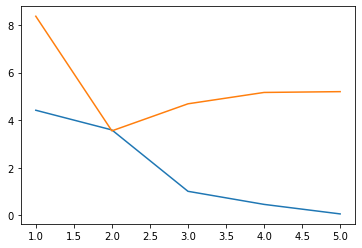

In [910]:
plt.plot(cnn.epo_lis,cnn.loss_lis)
plt.plot(cnn.epo_lis,cnn.val_lis)